# Поиск и классификация товаров народного потребления


**Цель** этой задачи — поиск и классификация конкретных категорий товаров в
огромном наборе различных наименований. Необходимо разметить
следующие категории:
- Хлебные изделия
- Напитки газированные
- Вода
- Молоко 2.5-3.2 %
- Молочные продукты
- Макароны
- Фрукты
- Продукция общепитов
- Товары без категории


Метрика в соревновании: 

Так как задача ставит перед собой цель — точное соотношения категорий, в
качестве метрики выступает recall.


## Импорт библиотек и модулей

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
! pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 8.2 MB 28.2 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=99e7b9f5ebb1b44eaf2e11d97eb5705bc8f1327d05d898d5d17cbcdf61644b32
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost import cv, Pool

import re

from wordcloud import WordCloud
from pymorphy2 import MorphAnalyzer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb

from sklearn.metrics import recall_score

%matplotlib inline

## Первичный анализ данных

In [ ]:
df = pd.read_csv("/content/train.csv")

In [ ]:
df_test = pd.read_csv("/content/test.csv")

In [ ]:
df.head()

,id,name,groups
0,1034,ШОК-ЦЕНА Пена д/душа/бритья КУППЕР 200 мл АКС,10
1,1035,Мин.вода Нагутская №26 0.5л,0
2,1036,Пельмени Домашние вес ПО Прямицино.,10
3,1037,ПЕЧЕНЬЕ ОВСЯНО-ГРЕЧНЕВОЕ ЭКО БОТ 4600508719365,10
4,1038,Спред растительно-жировой Масляничка 62% 170г ...,10


In [ ]:
df_test.head()

,id,name
0,10529,"КАРАМЕЛЬ ""ЛАКОМКА-СУПЕРМОЛОЧНАЯ"" ВЕС (РОТ ФРОНТ)"
1,10530,"2: 3637233 РАЭ Масло ТРАДИЦ.слив.82,5% 1"
2,10531,960012-LG NS Бинт эластичный Classic лаймовый...
3,10532,Вода мин. 1.5л пл/у (Сахалинская)
4,10533,Ролики натяжителя ремня AMD.GTA0740 AMD


In [ ]:
df.shape

(658064, 3)

In [ ]:
df_test.shape

(282227, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658064 entries, 0 to 658063
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      658064 non-null  int64 
 1   name    658064 non-null  object
 2   groups  658064 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 15.1+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282227 entries, 0 to 282226
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      282227 non-null  int64 
 1   name    282227 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


Посмотрим, какие группы встречаются в датасете

In [ ]:
df['groups'].value_counts()

10    502764
9      42002
4      27591
0      21566
3      21045
1      17136
7      12051
6      10007
2       3902
Name: groups, dtype: int64

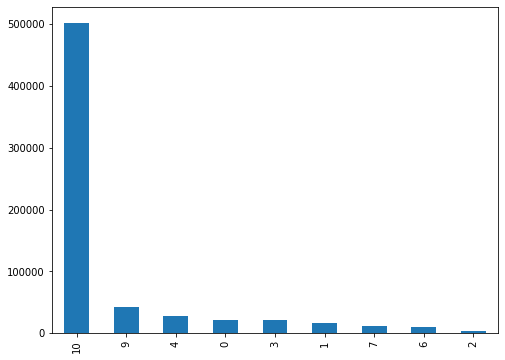

In [ ]:
fig = plt.figure(figsize=(8,6))
df['groups'].value_counts().plot.bar(ylim=0)
plt.show()

Мы видим, что категории распределены очень неравномерно

In [ ]:
categ = pd.read_excel('/content/categories.xlsx')

In [ ]:
categ

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,Наименование товара (услуги)-представителя,Код \nтовара (услуги),Общая характеристика товара (услуги)-представи...
8,Хлеб и булочные изделия из пшеничной муки разл...,9,Хлеб и булочные изделия из пшеничной муки высш...
9,"Напитки газированные, л",4,"Лимонад, содовая, кола и т.п., кроме кваса. За..."


## Предобработка

Добавим пару новых столбцов

In [ ]:
df["len name"] = df["name"].str.len()

In [ ]:
df_test["len name"] = df_test["name"].str.len()

In [ ]:
df.head(3)

,id,name,groups,len name
0,1034,ШОК-ЦЕНА Пена д/душа/бритья КУППЕР 200 мл АКС,10,45
1,1035,Мин.вода Нагутская №26 0.5л,0,30
2,1036,Пельмени Домашние вес ПО Прямицино.,10,35


In [ ]:
def text_prep(text):
  new_text = text.lower()
  new_text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,']", " ", new_text)

  return new_text

In [ ]:
df['text_cleaned'] = df['name'].apply(text_prep)

In [ ]:
df_test['text_cleaned'] = df_test['name'].apply(text_prep)

In [ ]:
df

,id,name,groups,len name,text_cleaned
0,1034,ШОК-ЦЕНА Пена д/душа/бритья КУППЕР 200 мл АКС,10,45,шок цена пена д душа бритья куппер 200 мл акс
1,1035,Мин.вода Нагутская №26 0.5л,0,30,мин вода нагутская №26 0 5л
2,1036,Пельмени Домашние вес ПО Прямицино.,10,35,пельмени домашние вес по прямицино
3,1037,ПЕЧЕНЬЕ ОВСЯНО-ГРЕЧНЕВОЕ ЭКО БОТ 4600508719365,10,46,печенье овсяно гречневое эко бот 4600508719365
4,1038,Спред растительно-жировой Масляничка 62% 170г ...,10,51,спред растительно жировой масляничка 62% 170г ...
...,...,...,...,...,...
658059,659093,"КАРАЧИНСКАЯ 1,5 л *6 шт мин вода",0,32,карачинская 1 5 л *6 шт мин вода
658060,659094,Хлеб ДОНСКОЙ 350г Рузский х/з,9,29,хлеб донской 350г рузский х з
658061,659095,Печенье сахарное FORSITE Сэндвич с шоколадно-с...,6,69,печенье сахарное forsite сэндвич с шоколадно с...
658062,659096,"Хлеб Бабушкин подов пшен 0,55кг п/уп(ШХЗ)",9,41,хлеб бабушкин подов пшен 0 55кг п уп шхз


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


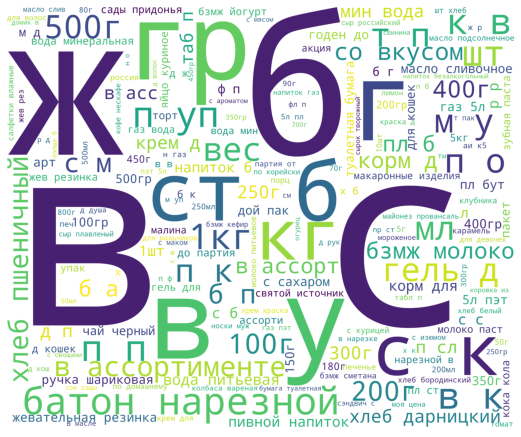

In [ ]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              #stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

corpus = get_corpus(df['text_cleaned'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

Попробуем лемматизацию

In [ ]:
'''
morph = MorphAnalyzer()

def lemmatize(doc):
  tokens = []
  for token in doc.split():
    token = token.strip()
    token = morph.normal_forms(token)[0]
            
    tokens.append(token)
  if len(tokens) > 2:
    return tokens
  return None'''

'\nmorph = MorphAnalyzer()\n\ndef lemmatize(doc):\n  tokens = []\n  for token in doc.split():\n    token = token.strip()\n    token = morph.normal_forms(token)[0]\n            \n    tokens.append(token)\n  if len(tokens) > 2:\n    return tokens\n  return None'

In [ ]:
#first = df.head(1)
#first['text_cleaned_lemm'] = first['text_cleaned'].apply(lemmatize)

In [ ]:
#first

In [ ]:
#corpus = df['text_cleaned'].values.astype('U')
#df['text_cleaned_lemm'] = df['text_cleaned'].apply(lemmatize)

In [ ]:
#df.to_csv("/content/df_lemm.csv", index = False)

In [ ]:
#df

In [ ]:
#corpus = df_test['text_cleaned'].values.astype('U')
#df_test['text_cleaned_lemm'] = df_test['text_cleaned'].apply(lemmatize)

In [ ]:
#df_test.to_csv("/content/df_test_lemm.csv", index = False)

In [ ]:
#df = pd.read_csv('/content/df_lemm.csv')

In [ ]:
#df['text_cleaned_lemm'] = df['text_cleaned_lemm'].astype(str)

In [ ]:
#df_test = pd.read_csv('/content/df_test_lemm.csv')

In [ ]:
#df_test['text_cleaned_lemm'] = df_test['text_cleaned_lemm'].astype(str)

In [ ]:
'''def text_prep(text):
  new_text = re.sub('[^a-zA-Zа-яА-ЯёЁ ]', '', text)
  new_text = re.sub("\[", "", new_text)
  new_text = re.sub("\]", "", new_text)
  new_text = re.sub("'", "", new_text)
  new_text = re.sub(",", "", new_text)

  return new_text'''

'def text_prep(text):\n  new_text = re.sub(\'[^a-zA-Zа-яА-ЯёЁ ]\', \'\', text)\n  new_text = re.sub("\\[", "", new_text)\n  new_text = re.sub("\\]", "", new_text)\n  new_text = re.sub("\'", "", new_text)\n  new_text = re.sub(",", "", new_text)\n\n  return new_text'

In [ ]:
#df['text_cleaned_lemm'] = df['text_cleaned_lemm'].apply(text_prep)

In [ ]:
#df_test['text_cleaned_lemm'] = df_test['text_cleaned_lemm'].apply(text_prep)

In [ ]:
#df

## ML

Разделим данные на выборки

In [ ]:
X = df.drop(['groups', 'name'], axis=1)
y = df['groups']

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
df_test["len name"] = df_test["name"].str.len()

In [ ]:
X_test = df_test.drop(['name'], axis=1)

In [ ]:
X

,id,len name,text_cleaned
0,1034,45,шок цена пена д душа бритья куппер 200 мл акс
1,1035,30,мин вода нагутская №26 0 5л
2,1036,35,пельмени домашние вес по прямицино
3,1037,46,печенье овсяно гречневое эко бот 4600508719365
4,1038,51,спред растительно жировой масляничка 62% 170г ...
...,...,...,...
658059,659093,32,карачинская 1 5 л *6 шт мин вода
658060,659094,29,хлеб донской 350г рузский х з
658061,659095,69,печенье сахарное forsite сэндвич с шоколадно с...
658062,659096,41,хлеб бабушкин подов пшен 0 55кг п уп шхз


In [ ]:
X_test

,id,len name,text_cleaned
0,10529,48,карамель лакомка супермолочная вес рот фронт
1,10530,40,2 3637233 раэ масло традиц слив 82 5% 1
2,10531,52,960012 lg ns бинт эластичный classic лаймовый...
3,10532,33,вода мин 1 5л пл у сахалинская
4,10533,39,ролики натяжителя ремня amd gta0740 amd
...,...,...,...
282222,292751,32,пельмени московские пижанка 800г
282223,292752,30,активиа 135гр пробиотик малина
282224,292753,15,базилик овощной
282225,292754,48,jacobs millicano кофе crema espresso раств с мол


In [ ]:
X_test = X_test.reindex(columns=['id', 'len name', 'text_cleaned'])

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282227 entries, 0 to 282226
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            282227 non-null  int64 
 1   len name      282227 non-null  int64 
 2   text_cleaned  282227 non-null  object
dtypes: int64(2), object(1)
memory usage: 6.5+ MB


In [ ]:
text_features = ['text_cleaned']

Сделаем классы сбалансированными

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

#### Catboost с текстовыми фичами

In [ ]:
#cat_ppl_clf = CatBoostClassifier(random_state=42, iterations=1001, depth = 8, text_features = text_features, loss_function='MultiClassOneVsAll', verbose=10, class_weights=class_weights, task_type="GPU")

In [ ]:
#cat_ppl_clf.fit(X, y)

In [ ]:
cat_clf = CatBoostClassifier(random_state=42, class_weights = class_weights, text_features = text_features, loss_function='MultiClassOneVsAll', verbose=10, task_type="GPU")

In [ ]:
parameters = { 
              'depth':[6, 7, 8, 9, 10, 11],
              'iterations':[701, 801, 901, 1001, 1101, 1201]
              }
model = GridSearchCV(cat_clf, parameters, cv=5).fit(X_train, y_train)
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)




Выходные данные были обрезаны до нескольких последних строк (5000).
890:	learn: 0.0171210	total: 45.4s	remaining: 10.7s
900:	learn: 0.0170661	total: 45.9s	remaining: 10.2s
910:	learn: 0.0169924	total: 46.3s	remaining: 9.67s
920:	learn: 0.0169221	total: 46.8s	remaining: 9.15s
930:	learn: 0.0168688	total: 47.3s	remaining: 8.64s
940:	learn: 0.0167966	total: 47.8s	remaining: 8.13s
950:	learn: 0.0167419	total: 48.3s	remaining: 7.62s
960:	learn: 0.0166682	total: 48.9s	remaining: 7.12s
970:	learn: 0.0166153	total: 49.3s	remaining: 6.61s
980:	learn: 0.0165517	total: 49.8s	remaining: 6.09s
990:	learn: 0.0164752	total: 50.3s	remaining: 5.58s
1000:	learn: 0.0164152	total: 50.8s	remaining: 5.08s
1010:	learn: 0.0163498	total: 51.3s	remaining: 4.57s
1020:	learn: 0.0162873	total: 51.8s	remaining: 4.06s
1030:	learn: 0.0162255	total: 52.3s	remaining: 3.55s
1040:	learn: 0.0161723	total: 52.8s	remaining: 3.04s
1050:	learn: 0.0161185	total: 53.3s	remaining: 2.53s
1060:	learn: 0.0160708	total: 53.8s	remain

####SGDClassifier + tf-idf

In [ ]:
#sgd_ppl_clf = Pipeline([
#    ('tfidf', TfidfVectorizer()),
#    ('sgd_clf', SGDClassifier(random_state=42))])
#knb_ppl_clf = Pipeline([
#    ('tfidf', TfidfVectorizer()),
#    ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

#sgd_ppl_clf.fit(X_train, y_train)
#knb_ppl_clf.fit(X_train, y_train)

In [ ]:
#predicted_sgd = sgd_ppl_clf.predict(X_valid)
#print(metrics.classification_report(predicted_sgd, y_valid))
#print(recall_score(predicted_sgd, y_valid, average='macro'))

In [ ]:
#predicted_sgd = knb_ppl_clf.predict(X_valid)
#print(metrics.classification_report(predicted_sgd, y_valid))

#### Catboost + tf-idf

In [ ]:
#cat_ppl_clf = Pipeline([
#    ('tfidf', TfidfVectorizer()),
#    ('cat_clf', #cat_ppl_clf = CatBoostClassifier(random_state=42, iterations=1001, depth = 8, text_features = text_features, loss_function='MultiClassOneVsAll', verbose=10, class_weights=class_weights, task_type="GPU")])

In [ ]:
#cat_ppl_clf.fit(X_train, y_train)

In [ ]:
#predicted_cat = cat_ppl_clf.predict(X_valid)
#print(metrics.classification_report(predicted_cat, y_valid))
#print(recall_score(predicted_cat, y_valid, average='macro'))

#### XGBClassifier

In [ ]:
#xgb_ppl_clf = Pipeline([
#    ('tfidf', TfidfVectorizer()),
#    ('xgb_clf', xgb.XGBClassifier(random_state=42))])

In [ ]:
#xgb_ppl_clf.fit(X_train, y_train)

In [ ]:
#predicted_xgb = xgb_ppl_clf.predict(X_valid)
#print(metrics.classification_report(predicted_xgb, y_valid))
#print(recall_score(predicted_xgb, y_valid, average='macro'))

In [ ]:
'''parameters = { 
              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'sgd_clf__class_weight':[None, 'balanced'],
              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'tfidf__strip_accents':['ascii', 'unicode', None],
               'tfidf__ngram_range':[(1,2), (2,3), (3,4)]
              }
model = GridSearchCV(sgd_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train, y_train)
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)'''

"parameters = { \n              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],\n              'sgd_clf__class_weight':[None, 'balanced'],\n              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet'],\n              'tfidf__strip_accents':['ascii', 'unicode', None],\n               'tfidf__ngram_range':[(1,2), (2,3), (3,4)]\n              }\nmodel = GridSearchCV(sgd_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train, y_train)\nprint('Best score and parameter combination:')\nprint(model.best_score_, model.best_params_)"

In [ ]:
'''sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', random_state=42))])
sgd_ppl_clf.fit(X_train, y_train)
predicted_sgd = sgd_ppl_clf.predict(X_valid)
print(metrics.classification_report(predicted_sgd, y_valid))'''

"sgd_ppl_clf = Pipeline([\n    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),\n    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', random_state=42))])\nsgd_ppl_clf.fit(X_train, y_train)\npredicted_sgd = sgd_ppl_clf.predict(X_valid)\nprint(metrics.classification_report(predicted_sgd, y_valid))"

In [ ]:
'''from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2))
features1 = tfidf.fit_transform(df1.text_cleaned).toarray()
labels1 = df1.groups
features1.shape'''

"from sklearn.feature_extraction.text import TfidfVectorizer\ntfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2))\nfeatures1 = tfidf.fit_transform(df1.text_cleaned).toarray()\nlabels1 = df1.groups\nfeatures1.shape"

Обучение на всей выборке

In [ ]:
#sgd_ppl_clf.fit(X, y)

In [ ]:
cat_clf.fit(X, y)

In [ ]:
#xgb_ppl_clf.fit(X, y)

## Cоздание файла с ответом

In [ ]:
#df_test_pred = sgd_ppl_clf.predict(X_test)

In [ ]:
df_test_pred = cat_clf.predict(X_test)

In [ ]:
#df_test_pred = xgb_ppl_clf.predict(X_test)

In [ ]:
df_sub = pd.read_csv('/content/sample_solution.csv')

In [ ]:
df_sub

,id,groups
0,10529,0
1,10530,0
2,10531,0
3,10532,0
4,10533,0
...,...,...
282222,292751,0
282223,292752,0
282224,292753,0
282225,292754,0


In [ ]:
df_sub["groups"] = df_test_pred
df_sub.head(4)

,id,groups
0,10529,10
1,10530,10
2,10531,10
3,10532,0


In [ ]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282227 entries, 0 to 282226
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id      282227 non-null  int64
 1   groups  282227 non-null  int64
dtypes: int64(2)
memory usage: 4.3 MB


In [ ]:
df_sub.to_csv("/content/submission.csv", index = False)